# Download Images
Following the optical flow gradient jupyter notebook effectiveness, the next step would be to obtain the images for:
1. Images of size `224x224x1` where each channel represents $d_{tx}$ or $d_{ty}$. We have a total of `2L`; representing the total amount of frames to analyze.

To do this, the following must be done:
1. Create code that would create an images folder
2. Create code that reads from the video, and performs the following:
    - Reads the frames for specific period
    - convert BGR to GRAY images to lower 3 channels to 1 channel.
    - Resize the Images to 224x224
    - Once a specific row of data read, calculate Optical gradients
    - Save the optical gradients images for later usage.
3. Look inside the images and see weather they are correct.

In [10]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from summarytools import dfSummary
import cv2
from tqdm import tqdm

In [11]:
# See of Data path exists
DATA_PATH = os.path.join(os.getcwd(), os.pardir, "data", "MultiCamFall")
print(os.path.exists(DATA_PATH))

VIDEO_PATH = os.path.join(DATA_PATH, "dataset", "dataset")
print(os.path.exists(VIDEO_PATH))

True
True


In [12]:
#lets obtain the metadata file
df_metadata = pd.read_csv(os.path.join(DATA_PATH, "data_tuple3.csv"))
df_metadata.loc[df_metadata["cam"] == 55, "cam"] = 3.0
dfSummary(df_metadata)

No,Variable,Stats / Values,Freqs / (% of Valid),Graph,Missing
1,chute[float64],Mean (sd) : 12.6 (7.0)min < med < max:1.0 < 12.0 < 23.0IQR (CV) : 13.0 (1.8),23 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACrUlEQVR4nO3cwYraUBSA4ZNmlIxCggi68wUKXbj0IfqwfYQufALfwJ0gEjEzwRgzi0EYSpvEe3ObnOT/9lEXP3XO6b16RVEI0HXf2v4AQB0vbX8AdIfnea8iMrZ4iWtRFO9NfZ6vCBUi8hnpfD7/GYbhzPQ1zufzyfO8Xy5iJVQ8jMMwnG02m/coitJnH47jONhut7Pj8TgWEUKFW1EUpYvF4s3w8ddGP8wXDFNQgVChAl/9aEye5yMRCT3PM3m8dGNAqGhEkiSjLMt+rFYr3/f9p4exqo0BoaIR1+v1JQiCyXq9TpfL5emZZ+tsDAgVjZpOp6Zbg9KNAcMUVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlSo/J8py+sJzq4mYFhKQ7W9nuDyagKGpepfVOPrCa6vJmBYah1Ksbie4OxqAoaFYQoqECpUcHoe1fJqgojSrQGbkuY5C9X2aoKIzq0BmxI3nIVqczVBRPXWgE2JA86volhcTRBRvDVgU9IshimoQKhQodO3UF3+oEEVi8k9vN/vI9P3xd91NlTXP2hQxmZyz7IsyPP8e5qmv0XE9G9z/KGzobr+QYMKxpP7fr+f7Xa7ye128w3eF//Q2VAfXP2gQR0mk/vpdGJqd4BhCioQKlTo/Fe/KcuNQWuT+1DPR1TpZai2G4O2Jvehno+oo5eh2p4zaGtyH/D5iEq9DPXBdGPQ9uQ+1PMRZRimoAKhQoVef/UPkcXWoNNnFAi1R2y2Bl0/o0CoPWKzNej6GQVC7SGTrUHbm44qDFNQgVChAqFCBUKFCoQKFQgVKhAqVCBUqECoUIFQoQKhQgVChQqEChUIFSoQKlQgVKhAqFCBUKECoUIFQoUKtS73xXEcPPvCl8slEBFJkiQ4HA6T//m81vfW+rltn6/T1we4BMahbQjBRwAAAABJRU5ErkJggg=="">",0(0.0%)
2,cam[float64],1. 1.02. 2.03. 3.04. 4.05. 5.06. 6.07. 7.08. 8.0,69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%)69 (12.5%),"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAJsAAAC4CAYAAAD0WZ4UAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACoklEQVR4nO3cQWrbUABF0a9iQjORMAYvxovoYrsI7cYYa9CETNxBh+0s4gbccxbwyeAiI/FfpsfjMaDw7av/AP4fYiMjNjJiIyM2MmIjM40xXscYLzud9/F4PN52OosnczidTj/meT7ucdi2bbdpmn4Kjn85zPN8vFwub8uyvH/moPv9/n1d1+P1en0ZY4iNvxzGGGNZlvfz+fxrh/NedziDJ+UFgYzYyIiNjNjIiI2M2MiIjYzYyIiNjNjIiI2M2MiIjcxhjD/Xgz570B5n8NwO27bd1nU9jh2uB23bdhtjfHz+z+IZuRZOZvLvF6h4spExeCFj8ELG4IWMj7pkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkDF7IGLyQcS2cjMELGS8IZPyMkrGuImNdRca6iowXBDJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjLWVWSsq8i4Fk7GuoqMJxsZgxcyBi9kDF7I+KhLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxuCFjMELGdfCyRi8kPGCQMbPKBnrKjLWVWSsq8h4QSAjNjJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiNjXUXGuoqMa+FkrKvIeLKRMXghY/BCxuCFjI+6ZMRGRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGxrqKjHUVGRsEMtZVZDzZyFhXkbGuImNdRcZHXTJiIyM2MmIjIzYyYiMjNjJiIyM2MmIjIzYyYiMjNjIGL2QMXsi4Fk7G4IWMJxsZgxcyBi9kDF7I+KhLRmxkxEZGbGTERkZsZMRGRmxkxEZGbGTERkZsZMRGRmxkrKvIWFeRsUEgY11FxgsCGbGRERsZsZERG5nfLZWuhBU4rK0AAAAASUVORK5CYII="">",0(0.0%)
3,start[float64],Mean (sd) : 745.9 (613.7)min < med < max:240.0 < 606.0 < 4166.0IQR (CV) : 288.5 (1.2),351 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGCAYAAABc8A97AAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjkuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8hTgPZAAAACXBIWXMAAA9hAAAPYQGoP6dpAAACYUlEQVR4nO3dPY7aUBSG4XP5iz0gA3IGOpoUdBSULGIWmy0gsQB6irQIa2SEA4E4ThOiSJEAX4uED71PzbmmeIXt5uCKojDg0dX+9xcAbtG49gHnXGhmLc/zj0VR7D1ngd8uhuqcC+M4fouiqO9z+Ha7fXfOfSZWVHXtF7UVRVF/Npvtu93uoczBaZoGi8WinyRJy8wIFZVcvfWbmXW73cNgMPjqcX7oMQP8hZcpSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSCBUSLhppY+vPM+bZhY553yPYBsgzOyOoWZZ1jydTpPRaFSv1+ulFqydsQ0QZ3cL9Xg8NoIgeJlOp4fhcPhedp5tgPjTXW/9Zmbtdtt3E6AZ2wDxCy9TkECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokECokHD3lT5VVNwGyCbAJ/KwoVbdBsgmwOfysKFW2QaYpmkwn88HSZJ8dM5tfb8CkT+Ohw31zGcbILtZn8/Dh+qD3azP5ylDPWM3aznOudDMWhWOqJnZD8/Zi49aTx0qbuecC+M4fouiqO8zn+d5M8uyT51OZ1Wr1U5l5689at0UapqmQdkL73a7wMwsy7JgvV6//Mv5qtdO0zTI87xh1f4oQ03U6XReJ5PJ9zAMv5Ud3mw2wWq1eh2Px196vd6uzOx+v/+wXC4vPmr9BG325f/zo2PcAAAAAElFTkSuQmCC"">",0(0.0%)
4,end[float64],Mean (sd) : 775.9 (613.7)min < med < max:270.0 < 636.0 < 4196.0IQR (CV) : 288.5 (1.3),351 distinct values,"<img src = ""data:image/png;base64, iVBORw0KGgoAAAANSUhEUgAAAKoAAABGC

In [13]:
df_metadata.head(12)

,chute,cam,start,end,label
0,1.0,1.0,1052.0,1082.0,0.0
1,1.0,1.0,1083.0,1113.0,1.0
2,1.0,1.0,1114.0,1144.0,0.0
3,1.0,2.0,1052.0,1082.0,0.0
4,1.0,2.0,1083.0,1113.0,1.0
5,1.0,2.0,1114.0,1144.0,0.0
6,1.0,3.0,1057.0,1087.0,0.0
7,1.0,3.0,1088.0,1118.0,1.0
8,1.0,3.0,1119.0,1149.0,0.0
9,1.0,4.0,1053.0,1083.0,0.0


### Create code that would create an images folder

In [14]:
# Images folder path
images_folder_path = os.path.join(os.getcwd(), "images")
if os.path.exists(images_folder_path) == False:
    os.makedirs(images_folder_path)

#Create two folders, one for fall and one for no fall
fall_folder_path = os.path.join(images_folder_path, "fall")
no_fall_folder_path = os.path.join(images_folder_path, "no_fall")
if os.path.exists(fall_folder_path) == False:
    os.makedirs(fall_folder_path)
if os.path.exists(no_fall_folder_path) == False:
    os.makedirs(no_fall_folder_path)


### Data Preprocessing
2. Create code that reads from the video, and performs the following:
    - Reads the frames for specific period
    - convert BGR to GRAY images to lower 3 channels to 1 channel.
    - Resize the Images to 224x224
    - Once a specific row of data read, calculate Optical gradients
    - Save the optical gradients images for later usage.

In [15]:
class PreprocessingElderMultiCamFall:
    '''
    Class that would Preprocess the Elder MultiCamFall dataset
    Parameters:
    df_metadata (pd.Dataframe): Dataframe containing the metadata of the dataset
    img_path (str): Path to the images folder
    height (int): Height of the images
    width (int): Width of the images
    '''
    def __init__(self, df_metadata:pd.DataFrame, img_path:str,\
            height:int = 224, width:int = 224, download_real:bool = True) -> None:
        
        #Set up all parameters
        self.df_metadata = df_metadata
        self.height = height
        self.width = width
        self.download_real = download_real
        
        #Set up the proper path for the images fall or no fall
        self.img_path = img_path
        self.fall_path = os.path.join(self.img_path, "fall")
        self.no_fall_path = os.path.join(self.img_path, "no_fall")

    def export_data(self) -> None:
        '''
        Method that exports the data to their respective folders
        '''
        for i in range(len(self.df_metadata)):
            row = self.df_metadata.iloc[i]
            self.get_row_data(row)

    def download_image(self, name:str, img:np.ndarray, fall_flag:bool)-> None:
        '''
        Function that download the image to the images folder
        '''
        if fall_flag == True:
            if os.path.exists(os.path.join(self.fall_path, name)) == False:
                cv2.imwrite(os.path.join(self.fall_path, name), img)
        else:
            if os.path.exists(os.path.join(self.no_fall_path, name)) == False:
                cv2.imwrite(os.path.join(self.no_fall_path, name), img)

    def compute_optical_flow(self, batch_frames:list[np.ndarray],\
            batch_nos:list[int], frame_name:str, fall_flag:bool = True) -> np.ndarray:
        """
        Computes the optical flow for a batch of consecutive image frames.
        
        Args:
            batch_frames (list[np.ndarray]): 4D NumPy array of shape (batch_size, height, width, 3)
                representing a batch of BGR images.
            batch_nos (list[int]): List of frame numbers corresponding to the batch of frames.
            frame_name(str): Name of the frame to be saved.
            fall_flag (bool): Flag indicating whether the frames are from a fall event.
        Returns:
            numpy.ndarray: 4D array of shape (batch_size-1, height, width, 2) with optical flow vectors.
        """
        batch_size, height, width, _ = np.array(batch_frames).shape

        # Convert batch to grayscale (required for optical flow computation)
        batch_gray = np.array([cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) for frame in batch_frames])

        for i in tqdm(range(batch_size - 1)):
            #flow = optical_flow.calc(batch_gray[i], batch_gray[i + 1], None)
            flow = cv2.calcOpticalFlowFarneback(batch_gray[i], batch_gray[i + 1], None,\
                pyr_scale=0.8, levels=5, winsize=10, iterations=5, poly_n=7, poly_sigma=1.1, flags=0)
            
            #This is experimental; to see the flow
            flow_data = np.zeros((height, width, 3), dtype=np.uint8)

            # Get the flow x and flow y
            flow_x = flow[:, :, 0]
            flow_y = flow[:, : ,1]

            #Assign it properly
            flow_data[:, :, 0] = flow_x
            flow_data[:, :, 1] = flow_y
            flow_data[:, :, 2] = batch_gray[i + 1]

            '''
            THIS BIT WAS FOR VISUALIZATION, BUT I THINK IT IS NOT NEEDED
            BASED ON EMPIRICAL EVIDENCE AND MAPPINGS.
            '''

            # # Compute magnitude and angle
            # magnitude, angle = cv2.cartToPolar(flow_x, flow_y)

            # # Map angle to Hue (0-180)
            # flow_data [:, :, 0] = angle * 180 / np.pi / 2
            # flow_data [:, :, 1] = 255

            # # Normalize magnitude to [0,255] and map to Value
            # flow_data [:, :, 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)
            # flow_data = cv2.cvtColor(flow_data, cv2.COLOR_HSV2BGR)

            # Save the flow data in .npy format
            if fall_flag:
                if os.path.exists(os.path.join(self.fall_path, f"{frame_name}_{batch_nos[i]}.npy")) == False:
                    np.save(os.path.join(self.fall_path, f"{frame_name}_{batch_nos[i]}.npy"), flow_data)
            else:
                if os.path.exists(os.path.join(self.fall_path, f"{frame_name}_{batch_nos[i]}.npy")) == False:
                    np.save(os.path.join(self.no_fall_path, f"{frame_name}_{batch_nos[i]}.npy"), flow_data)

    def get_row_data(self, row:pd.DataFrame) -> \
        None:
        """
        Extract a sequence of frames from a video file within the specified frame range.
        It also would retrieve the corresponding Fall/No fall event, for each
        specific frame, as well as frame time stamps in ms.

        Args:
            chute (int): The chute number identifying the video scenario
            cam (int): The camera number identifying the video perspective
            start (int): The starting frame number (inclusive)
            end (int): The ending frame number (exclusive)
            label (float): Referring to a Fall/No fall event. 1.0 or 0.0.

        Returns:
            None, Downloads the images in their respective folders :)
        
        Notes:
            In order to calculate the optical flow gradient flow, we calculate
            the difference between the current frame and the previous frame. This means
            that if we have labeled a window of 30 optical flows, we would need 31 frames
            to get them. Thats why in the code we have the -1 for start; to account for
            this difference.
        """
        
        #Obtain the important information
        chute = int(row['chute'])
        cam = int(row['cam'])
        start = int(row['start'])
        end = int(row['end'])
        label = int(row["label"])

        #Name of the video
        frame_name = f"chute{chute:02d}_cam{cam}_frames_{start}_{end}_"

        #Printing the message has started
        print(f"Scenario: {chute}, camera: {cam},\
            start: {start}, end {end}, label: {label}")
        print("Obtaining data....")

        # Read the video path to access the video files
        video_path = os.path.join(VIDEO_PATH, f"chute{chute:02d}", f"cam{cam}.avi")
        cap = cv2.VideoCapture(video_path)
        
        #Setup the lists to append frames, labels, and frames_ts
        frame_no = 1
        frames = []
        frames_nos = []

        # Read the first frame
        ret, frame = cap.read()

        # Loop over the frames
        while ret:

            # Skip frames outside of the start and end frames
            if frame_no < start - 1 or frame_no > end:
                ret, frame = cap.read()
                frame_no += 1
                continue

            if start - 1 <= frame_no < end:

                # Resize the frame to 224x224
                frame = cv2.resize(frame, (self.width, self.height))

                # If download real true, download the image
                if self.download_real:
                    if label == 1:
                        self.download_image(frame_name + f"_{frame_no}.jpg", frame, fall_flag=True)
                    else:
                        self.download_image(frame_name + f"_{frame_no}.jpg", frame, fall_flag=False)

                frames.append(frame)

            #Append it
            frames_nos.append(frame_no)

            # Follow with the next frame
            frame_no += 1

            # Read the next frame
            ret, frame = cap.read()

        # Release the video capture
        cap.release()

        # Pass the frames and get the data
        if label == 1:
            self.compute_optical_flow(frames, frames_nos, frame_name, fall_flag=True)
        else:
            self.compute_optical_flow(frames, frames_nos, frame_name, fall_flag=False)

        print("Data obtained")

### LETS DOWNLOAD THE DATA

In [16]:
DATA_LOADER = PreprocessingElderMultiCamFall(df_metadata,\
    height=224, width=224, img_path=images_folder_path)
DATA_LOADER.export_data()

Scenario: 1, camera: 1,            start: 1052, end 1082, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.35it/s]


Data obtained
Scenario: 1, camera: 1,            start: 1083, end 1113, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.73it/s]


Data obtained
Scenario: 1, camera: 1,            start: 1114, end 1144, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.31it/s]


Data obtained
Scenario: 1, camera: 2,            start: 1052, end 1082, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.76it/s]


Data obtained
Scenario: 1, camera: 2,            start: 1083, end 1113, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.17it/s]


Data obtained
Scenario: 1, camera: 2,            start: 1114, end 1144, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.50it/s]


Data obtained
Scenario: 1, camera: 3,            start: 1057, end 1087, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.04it/s]


Data obtained
Scenario: 1, camera: 3,            start: 1088, end 1118, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.32it/s]


Data obtained
Scenario: 1, camera: 3,            start: 1119, end 1149, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.27it/s]


Data obtained
Scenario: 1, camera: 4,            start: 1053, end 1083, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.17it/s]


Data obtained
Scenario: 1, camera: 4,            start: 1084, end 1114, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.30it/s]


Data obtained
Scenario: 1, camera: 4,            start: 1115, end 1145, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.64it/s]


Data obtained
Scenario: 1, camera: 5,            start: 1072, end 1102, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.29it/s]


Data obtained
Scenario: 1, camera: 5,            start: 1103, end 1133, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.14it/s]


Data obtained
Scenario: 1, camera: 5,            start: 1134, end 1164, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.30it/s]


Data obtained
Scenario: 1, camera: 6,            start: 1055, end 1085, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.05it/s]


Data obtained
Scenario: 1, camera: 6,            start: 1086, end 1116, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.13it/s]


Data obtained
Scenario: 1, camera: 6,            start: 1117, end 1147, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.10it/s]


Data obtained
Scenario: 1, camera: 7,            start: 1055, end 1085, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.11it/s]


Data obtained
Scenario: 1, camera: 7,            start: 1086, end 1116, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.86it/s]


Data obtained
Scenario: 1, camera: 7,            start: 1117, end 1147, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.54it/s]


Data obtained
Scenario: 1, camera: 8,            start: 1049, end 1079, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.40it/s]


Data obtained
Scenario: 1, camera: 8,            start: 1080, end 1110, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.91it/s]


Data obtained
Scenario: 1, camera: 8,            start: 1111, end 1141, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.43it/s]


Data obtained
Scenario: 2, camera: 1,            start: 369, end 399, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.66it/s]


Data obtained
Scenario: 2, camera: 1,            start: 400, end 430, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.18it/s]


Data obtained
Scenario: 2, camera: 1,            start: 430, end 460, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.79it/s]


Data obtained
Scenario: 2, camera: 2,            start: 384, end 414, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.92it/s]


Data obtained
Scenario: 2, camera: 2,            start: 415, end 445, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.52it/s]


Data obtained
Scenario: 2, camera: 2,            start: 445, end 475, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.04it/s]


Data obtained
Scenario: 2, camera: 3,            start: 344, end 374, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.41it/s]


Data obtained
Scenario: 2, camera: 3,            start: 375, end 405, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.46it/s]


Data obtained
Scenario: 2, camera: 3,            start: 405, end 435, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.44it/s]


Data obtained
Scenario: 2, camera: 4,            start: 360, end 390, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.39it/s]


Data obtained
Scenario: 2, camera: 4,            start: 391, end 421, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.44it/s]


Data obtained
Scenario: 2, camera: 4,            start: 421, end 451, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.85it/s]


Data obtained
Scenario: 2, camera: 5,            start: 362, end 392, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.96it/s]


Data obtained
Scenario: 2, camera: 5,            start: 393, end 423, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.58it/s]


Data obtained
Scenario: 2, camera: 5,            start: 423, end 453, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.69it/s]


Data obtained
Scenario: 2, camera: 6,            start: 377, end 407, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.29it/s]


Data obtained
Scenario: 2, camera: 6,            start: 408, end 438, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.53it/s]


Data obtained
Scenario: 2, camera: 6,            start: 438, end 468, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.78it/s]


Data obtained
Scenario: 2, camera: 7,            start: 377, end 407, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.86it/s]


Data obtained
Scenario: 2, camera: 7,            start: 408, end 438, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.83it/s]


Data obtained
Scenario: 2, camera: 7,            start: 438, end 468, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.35it/s]


Data obtained
Scenario: 2, camera: 8,            start: 350, end 380, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 48.08it/s]


Data obtained
Scenario: 2, camera: 8,            start: 381, end 411, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.75it/s]


Data obtained
Scenario: 2, camera: 8,            start: 411, end 441, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.69it/s]


Data obtained
Scenario: 3, camera: 1,            start: 572, end 602, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.06it/s]


Data obtained
Scenario: 3, camera: 1,            start: 603, end 633, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.84it/s]


Data obtained
Scenario: 3, camera: 2,            start: 576, end 606, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.68it/s]


Data obtained
Scenario: 3, camera: 2,            start: 607, end 637, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.23it/s]


Data obtained
Scenario: 3, camera: 3,            start: 568, end 598, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.87it/s]


Data obtained
Scenario: 3, camera: 3,            start: 599, end 629, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.69it/s]


Data obtained
Scenario: 3, camera: 4,            start: 576, end 606, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.73it/s]


Data obtained
Scenario: 3, camera: 4,            start: 607, end 637, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.40it/s]


Data obtained
Scenario: 3, camera: 5,            start: 595, end 625, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.03it/s]


Data obtained
Scenario: 3, camera: 5,            start: 626, end 656, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.39it/s]


Data obtained
Scenario: 3, camera: 6,            start: 580, end 610, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.70it/s]


Data obtained
Scenario: 3, camera: 6,            start: 611, end 641, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.21it/s]


Data obtained
Scenario: 3, camera: 7,            start: 580, end 610, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.72it/s]


Data obtained
Scenario: 3, camera: 7,            start: 611, end 641, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.69it/s]


Data obtained
Scenario: 3, camera: 8,            start: 560, end 590, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.73it/s]


Data obtained
Scenario: 3, camera: 8,            start: 591, end 621, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.82it/s]


Data obtained
Scenario: 4, camera: 1,            start: 329, end 359, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.74it/s]


Data obtained
Scenario: 4, camera: 1,            start: 360, end 390, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.00it/s]


Data obtained
Scenario: 4, camera: 1,            start: 391, end 421, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.63it/s]


Data obtained
Scenario: 4, camera: 1,            start: 676, end 706, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.00it/s]


Data obtained
Scenario: 4, camera: 1,            start: 707, end 737, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.44it/s]


Data obtained
Scenario: 4, camera: 2,            start: 336, end 366, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.27it/s]


Data obtained
Scenario: 4, camera: 2,            start: 367, end 397, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.43it/s]


Data obtained
Scenario: 4, camera: 2,            start: 398, end 428, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.92it/s]


Data obtained
Scenario: 4, camera: 2,            start: 683, end 713, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.87it/s]


Data obtained
Scenario: 4, camera: 2,            start: 714, end 744, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.11it/s]


Data obtained
Scenario: 4, camera: 3,            start: 335, end 365, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.46it/s]


Data obtained
Scenario: 4, camera: 3,            start: 366, end 396, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.70it/s]


Data obtained
Scenario: 4, camera: 3,            start: 397, end 427, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.99it/s]


Data obtained
Scenario: 4, camera: 3,            start: 682, end 712, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.64it/s]


Data obtained
Scenario: 4, camera: 3,            start: 713, end 743, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.17it/s]


Data obtained
Scenario: 4, camera: 4,            start: 257, end 287, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.11it/s]


Data obtained
Scenario: 4, camera: 4,            start: 288, end 318, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.52it/s]


Data obtained
Scenario: 4, camera: 4,            start: 319, end 349, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.77it/s]


Data obtained
Scenario: 4, camera: 4,            start: 604, end 634, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.98it/s]


Data obtained
Scenario: 4, camera: 4,            start: 635, end 665, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.05it/s]


Data obtained
Scenario: 4, camera: 5,            start: 325, end 355, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.34it/s]


Data obtained
Scenario: 4, camera: 5,            start: 356, end 386, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.42it/s]


Data obtained
Scenario: 4, camera: 5,            start: 387, end 417, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.29it/s]


Data obtained
Scenario: 4, camera: 5,            start: 672, end 702, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.71it/s]


Data obtained
Scenario: 4, camera: 5,            start: 703, end 733, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.31it/s]


Data obtained
Scenario: 4, camera: 6,            start: 339, end 369, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.79it/s]


Data obtained
Scenario: 4, camera: 6,            start: 370, end 400, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.52it/s]


Data obtained
Scenario: 4, camera: 6,            start: 401, end 431, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.70it/s]


Data obtained
Scenario: 4, camera: 6,            start: 686, end 716, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.25it/s]


Data obtained
Scenario: 4, camera: 6,            start: 717, end 747, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.73it/s]


Data obtained
Scenario: 4, camera: 7,            start: 340, end 370, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.81it/s]


Data obtained
Scenario: 4, camera: 7,            start: 371, end 401, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.13it/s]


Data obtained
Scenario: 4, camera: 7,            start: 402, end 432, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.58it/s]


Data obtained
Scenario: 4, camera: 7,            start: 687, end 717, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.40it/s]


Data obtained
Scenario: 4, camera: 7,            start: 718, end 748, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.07it/s]


Data obtained
Scenario: 4, camera: 8,            start: 313, end 343, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.88it/s]


Data obtained
Scenario: 4, camera: 8,            start: 344, end 374, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.90it/s]


Data obtained
Scenario: 4, camera: 8,            start: 375, end 405, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.62it/s]


Data obtained
Scenario: 4, camera: 8,            start: 660, end 690, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.65it/s]


Data obtained
Scenario: 4, camera: 8,            start: 691, end 721, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.85it/s]


Data obtained
Scenario: 5, camera: 1,            start: 326, end 356, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.86it/s]


Data obtained
Scenario: 5, camera: 1,            start: 357, end 387, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.56it/s]


Data obtained
Scenario: 5, camera: 2,            start: 333, end 363, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.85it/s]


Data obtained
Scenario: 5, camera: 2,            start: 364, end 394, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.27it/s]


Data obtained
Scenario: 5, camera: 3,            start: 314, end 344, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.23it/s]


Data obtained
Scenario: 5, camera: 3,            start: 345, end 375, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 47.01it/s]


Data obtained
Scenario: 5, camera: 4,            start: 320, end 350, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.29it/s]


Data obtained
Scenario: 5, camera: 4,            start: 351, end 381, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.71it/s]


Data obtained
Scenario: 5, camera: 5,            start: 327, end 357, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.12it/s]


Data obtained
Scenario: 5, camera: 5,            start: 358, end 388, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.65it/s]


Data obtained
Scenario: 5, camera: 6,            start: 335, end 365, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.06it/s]


Data obtained
Scenario: 5, camera: 6,            start: 366, end 396, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.12it/s]


Data obtained
Scenario: 5, camera: 7,            start: 337, end 367, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.35it/s]


Data obtained
Scenario: 5, camera: 7,            start: 368, end 398, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.78it/s]


Data obtained
Scenario: 5, camera: 8,            start: 309, end 339, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 46.54it/s]


Data obtained
Scenario: 5, camera: 8,            start: 340, end 370, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.91it/s]


Data obtained
Scenario: 6, camera: 1,            start: 532, end 562, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.65it/s]


Data obtained
Scenario: 6, camera: 1,            start: 583, end 613, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.79it/s]


Data obtained
Scenario: 6, camera: 1,            start: 603, end 633, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.76it/s]


Data obtained
Scenario: 6, camera: 1,            start: 640, end 670, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.72it/s]


Data obtained
Scenario: 6, camera: 2,            start: 632, end 662, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.46it/s]


Data obtained
Scenario: 6, camera: 2,            start: 683, end 713, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.87it/s]


Data obtained
Scenario: 6, camera: 2,            start: 703, end 733, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.95it/s]


Data obtained
Scenario: 6, camera: 2,            start: 740, end 770, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.93it/s]


Data obtained
Scenario: 6, camera: 3,            start: 638, end 668, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.15it/s]


Data obtained
Scenario: 6, camera: 3,            start: 689, end 719, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.96it/s]


Data obtained
Scenario: 6, camera: 3,            start: 709, end 739, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.38it/s]


Data obtained
Scenario: 6, camera: 3,            start: 746, end 776, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.87it/s]


Data obtained
Scenario: 6, camera: 4,            start: 622, end 652, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.63it/s]


Data obtained
Scenario: 6, camera: 4,            start: 673, end 703, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.14it/s]


Data obtained
Scenario: 6, camera: 4,            start: 693, end 723, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.65it/s]


Data obtained
Scenario: 6, camera: 4,            start: 730, end 760, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.48it/s]


Data obtained
Scenario: 6, camera: 5,            start: 622, end 652, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.40it/s]


Data obtained
Scenario: 6, camera: 5,            start: 673, end 703, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.09it/s]


Data obtained
Scenario: 6, camera: 5,            start: 693, end 723, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.43it/s]


Data obtained
Scenario: 6, camera: 5,            start: 730, end 760, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.96it/s]


Data obtained
Scenario: 6, camera: 6,            start: 635, end 665, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.75it/s]


Data obtained
Scenario: 6, camera: 6,            start: 686, end 716, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.13it/s]


Data obtained
Scenario: 6, camera: 6,            start: 706, end 736, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.04it/s]


Data obtained
Scenario: 6, camera: 6,            start: 743, end 773, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.91it/s]


Data obtained
Scenario: 6, camera: 7,            start: 635, end 665, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.31it/s]


Data obtained
Scenario: 6, camera: 7,            start: 686, end 716, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.62it/s]


Data obtained
Scenario: 6, camera: 7,            start: 706, end 736, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.26it/s]


Data obtained
Scenario: 6, camera: 7,            start: 743, end 773, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.67it/s]


Data obtained
Scenario: 6, camera: 8,            start: 621, end 651, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.45it/s]


Data obtained
Scenario: 6, camera: 8,            start: 672, end 702, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.15it/s]


Data obtained
Scenario: 6, camera: 8,            start: 692, end 722, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.75it/s]


Data obtained
Scenario: 6, camera: 8,            start: 729, end 759, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.03it/s]


Data obtained
Scenario: 7, camera: 1,            start: 473, end 503, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.76it/s]


Data obtained
Scenario: 7, camera: 1,            start: 504, end 534, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.92it/s]


Data obtained
Scenario: 7, camera: 2,            start: 460, end 490, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 33.05it/s]


Data obtained
Scenario: 7, camera: 2,            start: 491, end 521, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.44it/s]


Data obtained
Scenario: 7, camera: 3,            start: 460, end 490, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.22it/s]


Data obtained
Scenario: 7, camera: 3,            start: 491, end 521, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.67it/s]


Data obtained
Scenario: 7, camera: 4,            start: 445, end 475, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.11it/s]


Data obtained
Scenario: 7, camera: 4,            start: 476, end 506, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.06it/s]


Data obtained
Scenario: 7, camera: 5,            start: 463, end 493, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 45.50it/s]


Data obtained
Scenario: 7, camera: 5,            start: 494, end 524, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.69it/s]


Data obtained
Scenario: 7, camera: 6,            start: 463, end 493, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.61it/s]


Data obtained
Scenario: 7, camera: 6,            start: 494, end 524, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 28.16it/s]


Data obtained
Scenario: 7, camera: 7,            start: 463, end 493, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 32.43it/s]


Data obtained
Scenario: 7, camera: 7,            start: 494, end 524, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.04it/s]


Data obtained
Scenario: 7, camera: 8,            start: 463, end 493, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 28.95it/s]


Data obtained
Scenario: 7, camera: 8,            start: 494, end 524, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.50it/s]


Data obtained
Scenario: 8, camera: 1,            start: 332, end 362, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.05it/s]


Data obtained
Scenario: 8, camera: 1,            start: 363, end 393, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.18it/s]


Data obtained
Scenario: 8, camera: 2,            start: 319, end 349, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.94it/s]


Data obtained
Scenario: 8, camera: 2,            start: 350, end 380, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.42it/s]


Data obtained
Scenario: 8, camera: 3,            start: 240, end 270, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.99it/s]


Data obtained
Scenario: 8, camera: 3,            start: 271, end 301, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.57it/s]


Data obtained
Scenario: 8, camera: 4,            start: 321, end 351, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.92it/s]


Data obtained
Scenario: 8, camera: 4,            start: 352, end 382, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.14it/s]


Data obtained
Scenario: 8, camera: 5,            start: 304, end 334, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.38it/s]


Data obtained
Scenario: 8, camera: 5,            start: 335, end 365, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.34it/s]


Data obtained
Scenario: 8, camera: 6,            start: 321, end 351, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.46it/s]


Data obtained
Scenario: 8, camera: 6,            start: 352, end 382, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.02it/s]


Data obtained
Scenario: 8, camera: 7,            start: 321, end 351, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.95it/s]


Data obtained
Scenario: 8, camera: 7,            start: 352, end 382, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.73it/s]


Data obtained
Scenario: 8, camera: 8,            start: 296, end 326, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.15it/s]


Data obtained
Scenario: 8, camera: 8,            start: 327, end 357, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.23it/s]


Data obtained
Scenario: 9, camera: 1,            start: 612, end 642, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.32it/s]


Data obtained
Scenario: 9, camera: 1,            start: 643, end 673, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.01it/s]


Data obtained
Scenario: 9, camera: 1,            start: 674, end 704, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.99it/s]


Data obtained
Scenario: 9, camera: 2,            start: 603, end 633, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 32.79it/s]


Data obtained
Scenario: 9, camera: 2,            start: 634, end 664, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.85it/s]


Data obtained
Scenario: 9, camera: 2,            start: 665, end 695, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.29it/s]


Data obtained
Scenario: 9, camera: 3,            start: 594, end 624, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.81it/s]


Data obtained
Scenario: 9, camera: 3,            start: 625, end 655, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.81it/s]


Data obtained
Scenario: 9, camera: 3,            start: 656, end 686, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.66it/s]


Data obtained
Scenario: 9, camera: 4,            start: 612, end 642, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.31it/s]


Data obtained
Scenario: 9, camera: 4,            start: 643, end 673, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.40it/s]


Data obtained
Scenario: 9, camera: 4,            start: 674, end 704, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.67it/s]


Data obtained
Scenario: 9, camera: 5,            start: 606, end 636, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.69it/s]


Data obtained
Scenario: 9, camera: 5,            start: 637, end 667, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.03it/s]


Data obtained
Scenario: 9, camera: 5,            start: 668, end 698, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.14it/s]


Data obtained
Scenario: 9, camera: 6,            start: 606, end 636, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 36.37it/s]


Data obtained
Scenario: 9, camera: 6,            start: 637, end 667, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.35it/s]


Data obtained
Scenario: 9, camera: 6,            start: 668, end 698, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.39it/s]


Data obtained
Scenario: 9, camera: 7,            start: 606, end 636, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.48it/s]


Data obtained
Scenario: 9, camera: 7,            start: 637, end 667, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.12it/s]


Data obtained
Scenario: 9, camera: 7,            start: 668, end 698, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.19it/s]


Data obtained
Scenario: 9, camera: 8,            start: 594, end 624, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 33.26it/s]


Data obtained
Scenario: 9, camera: 8,            start: 625, end 655, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.30it/s]


Data obtained
Scenario: 9, camera: 8,            start: 656, end 686, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.40it/s]


Data obtained
Scenario: 10, camera: 1,            start: 499, end 529, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.31it/s]


Data obtained
Scenario: 10, camera: 1,            start: 520, end 550, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.80it/s]


Data obtained
Scenario: 10, camera: 1,            start: 551, end 581, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.82it/s]


Data obtained
Scenario: 10, camera: 2,            start: 499, end 529, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.04it/s]


Data obtained
Scenario: 10, camera: 2,            start: 520, end 550, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.16it/s]


Data obtained
Scenario: 10, camera: 2,            start: 551, end 581, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.71it/s]


Data obtained
Scenario: 10, camera: 3,            start: 504, end 534, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.73it/s]


Data obtained
Scenario: 10, camera: 3,            start: 525, end 555, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.67it/s]


Data obtained
Scenario: 10, camera: 3,            start: 556, end 586, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.32it/s]


Data obtained
Scenario: 10, camera: 4,            start: 518, end 548, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.26it/s]


Data obtained
Scenario: 10, camera: 4,            start: 539, end 569, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.68it/s]


Data obtained
Scenario: 10, camera: 4,            start: 570, end 600, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.62it/s]


Data obtained
Scenario: 10, camera: 5,            start: 497, end 527, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.68it/s]


Data obtained
Scenario: 10, camera: 5,            start: 518, end 548, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.75it/s]


Data obtained
Scenario: 10, camera: 5,            start: 549, end 579, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.38it/s]


Data obtained
Scenario: 10, camera: 6,            start: 502, end 532, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.40it/s]


Data obtained
Scenario: 10, camera: 6,            start: 523, end 553, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 36.88it/s]


Data obtained
Scenario: 10, camera: 6,            start: 554, end 584, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.00it/s]


Data obtained
Scenario: 10, camera: 7,            start: 504, end 534, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.06it/s]


Data obtained
Scenario: 10, camera: 7,            start: 525, end 555, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.51it/s]


Data obtained
Scenario: 10, camera: 7,            start: 556, end 586, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.53it/s]


Data obtained
Scenario: 10, camera: 8,            start: 485, end 515, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.65it/s]


Data obtained
Scenario: 10, camera: 8,            start: 506, end 536, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.54it/s]


Data obtained
Scenario: 10, camera: 8,            start: 537, end 567, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.45it/s]


Data obtained
Scenario: 11, camera: 1,            start: 454, end 484, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.30it/s]


Data obtained
Scenario: 11, camera: 1,            start: 485, end 515, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.23it/s]


Data obtained
Scenario: 11, camera: 1,            start: 516, end 546, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.35it/s]


Data obtained
Scenario: 11, camera: 2,            start: 435, end 465, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.60it/s]


Data obtained
Scenario: 11, camera: 2,            start: 466, end 496, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.35it/s]


Data obtained
Scenario: 11, camera: 2,            start: 497, end 527, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.40it/s]


Data obtained
Scenario: 11, camera: 3,            start: 451, end 481, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.41it/s]


Data obtained
Scenario: 11, camera: 3,            start: 482, end 512, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.51it/s]


Data obtained
Scenario: 11, camera: 3,            start: 513, end 543, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.04it/s]


Data obtained
Scenario: 11, camera: 4,            start: 445, end 475, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.86it/s]


Data obtained
Scenario: 11, camera: 4,            start: 476, end 506, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.75it/s]


Data obtained
Scenario: 11, camera: 4,            start: 507, end 537, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.20it/s]


Data obtained
Scenario: 11, camera: 5,            start: 431, end 461, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.18it/s]


Data obtained
Scenario: 11, camera: 5,            start: 462, end 492, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.39it/s]


Data obtained
Scenario: 11, camera: 5,            start: 493, end 523, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.45it/s]


Data obtained
Scenario: 11, camera: 6,            start: 437, end 467, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 35.07it/s]


Data obtained
Scenario: 11, camera: 6,            start: 468, end 498, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.46it/s]


Data obtained
Scenario: 11, camera: 6,            start: 499, end 529, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 35.76it/s]


Data obtained
Scenario: 11, camera: 7,            start: 437, end 467, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.00it/s]


Data obtained
Scenario: 11, camera: 7,            start: 468, end 498, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.57it/s]


Data obtained
Scenario: 11, camera: 7,            start: 499, end 529, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.86it/s]


Data obtained
Scenario: 11, camera: 8,            start: 443, end 473, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.04it/s]


Data obtained
Scenario: 11, camera: 8,            start: 474, end 504, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.78it/s]


Data obtained
Scenario: 11, camera: 8,            start: 505, end 535, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.35it/s]


Data obtained
Scenario: 12, camera: 1,            start: 590, end 620, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.25it/s]


Data obtained
Scenario: 12, camera: 1,            start: 621, end 651, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.96it/s]


Data obtained
Scenario: 12, camera: 1,            start: 649, end 679, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.02it/s]


Data obtained
Scenario: 12, camera: 2,            start: 575, end 605, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.46it/s]


Data obtained
Scenario: 12, camera: 2,            start: 606, end 636, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.83it/s]


Data obtained
Scenario: 12, camera: 2,            start: 634, end 664, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.94it/s]


Data obtained
Scenario: 12, camera: 3,            start: 582, end 612, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.29it/s]


Data obtained
Scenario: 12, camera: 3,            start: 613, end 643, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.55it/s]


Data obtained
Scenario: 12, camera: 3,            start: 641, end 671, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.80it/s]


Data obtained
Scenario: 12, camera: 4,            start: 577, end 607, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.24it/s]


Data obtained
Scenario: 12, camera: 4,            start: 608, end 638, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.48it/s]


Data obtained
Scenario: 12, camera: 4,            start: 636, end 666, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.12it/s]


Data obtained
Scenario: 12, camera: 5,            start: 569, end 599, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.08it/s]


Data obtained
Scenario: 12, camera: 5,            start: 600, end 630, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.77it/s]


Data obtained
Scenario: 12, camera: 5,            start: 628, end 658, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.57it/s]


Data obtained
Scenario: 12, camera: 6,            start: 572, end 602, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.46it/s]


Data obtained
Scenario: 12, camera: 6,            start: 603, end 633, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 29.62it/s]


Data obtained
Scenario: 12, camera: 6,            start: 631, end 661, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.92it/s]


Data obtained
Scenario: 12, camera: 7,            start: 576, end 606, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.98it/s]


Data obtained
Scenario: 12, camera: 7,            start: 607, end 637, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.80it/s]


Data obtained
Scenario: 12, camera: 7,            start: 635, end 665, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.35it/s]


Data obtained
Scenario: 12, camera: 8,            start: 569, end 599, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.74it/s]


Data obtained
Scenario: 12, camera: 8,            start: 600, end 630, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.93it/s]


Data obtained
Scenario: 12, camera: 8,            start: 628, end 658, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.85it/s]


Data obtained
Scenario: 13, camera: 1,            start: 703, end 733, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.80it/s]


Data obtained
Scenario: 13, camera: 1,            start: 844, end 874, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.40it/s]


Data obtained
Scenario: 13, camera: 2,            start: 720, end 750, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.59it/s]


Data obtained
Scenario: 13, camera: 2,            start: 861, end 891, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.94it/s]


Data obtained
Scenario: 13, camera: 3,            start: 687, end 717, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.51it/s]


Data obtained
Scenario: 13, camera: 3,            start: 828, end 858, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.28it/s]


Data obtained
Scenario: 13, camera: 4,            start: 694, end 724, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.86it/s]


Data obtained
Scenario: 13, camera: 4,            start: 835, end 865, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.81it/s]


Data obtained
Scenario: 13, camera: 5,            start: 714, end 744, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.12it/s]


Data obtained
Scenario: 13, camera: 5,            start: 855, end 885, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.27it/s]


Data obtained
Scenario: 13, camera: 6,            start: 714, end 744, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.63it/s]


Data obtained
Scenario: 13, camera: 6,            start: 855, end 885, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.60it/s]


Data obtained
Scenario: 13, camera: 7,            start: 723, end 753, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.82it/s]


Data obtained
Scenario: 13, camera: 7,            start: 864, end 894, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.88it/s]


Data obtained
Scenario: 13, camera: 8,            start: 700, end 730, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.64it/s]


Data obtained
Scenario: 13, camera: 8,            start: 841, end 871, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.55it/s]


Data obtained
Scenario: 14, camera: 1,            start: 1040, end 1070, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.33it/s]


Data obtained
Scenario: 14, camera: 1,            start: 1071, end 1101, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.45it/s]


Data obtained
Scenario: 14, camera: 2,            start: 1027, end 1057, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.40it/s]


Data obtained
Scenario: 14, camera: 2,            start: 1058, end 1088, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.55it/s]


Data obtained
Scenario: 14, camera: 3,            start: 1029, end 1059, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.79it/s]


Data obtained
Scenario: 14, camera: 3,            start: 1060, end 1090, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.39it/s]


Data obtained
Scenario: 14, camera: 4,            start: 991, end 1021, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.49it/s]


Data obtained
Scenario: 14, camera: 4,            start: 1022, end 1052, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.31it/s]


Data obtained
Scenario: 14, camera: 5,            start: 1019, end 1049, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.15it/s]


Data obtained
Scenario: 14, camera: 5,            start: 1050, end 1080, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.82it/s]


Data obtained
Scenario: 14, camera: 6,            start: 1019, end 1049, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.40it/s]


Data obtained
Scenario: 14, camera: 6,            start: 1050, end 1080, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 38.77it/s]


Data obtained
Scenario: 14, camera: 7,            start: 998, end 1028, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.53it/s]


Data obtained
Scenario: 14, camera: 7,            start: 1029, end 1059, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.02it/s]


Data obtained
Scenario: 14, camera: 8,            start: 1005, end 1035, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.28it/s]


Data obtained
Scenario: 14, camera: 8,            start: 1036, end 1066, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.83it/s]


Data obtained
Scenario: 15, camera: 1,            start: 739, end 769, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.12it/s]


Data obtained
Scenario: 15, camera: 1,            start: 770, end 800, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.49it/s]


Data obtained
Scenario: 15, camera: 2,            start: 743, end 773, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.29it/s]


Data obtained
Scenario: 15, camera: 2,            start: 774, end 804, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.16it/s]


Data obtained
Scenario: 15, camera: 3,            start: 743, end 773, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.45it/s]


Data obtained
Scenario: 15, camera: 3,            start: 774, end 804, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.21it/s]


Data obtained
Scenario: 15, camera: 4,            start: 739, end 769, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.77it/s]


Data obtained
Scenario: 15, camera: 4,            start: 770, end 800, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.32it/s]


Data obtained
Scenario: 15, camera: 5,            start: 758, end 788, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.42it/s]


Data obtained
Scenario: 15, camera: 5,            start: 789, end 819, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 31.14it/s]


Data obtained
Scenario: 15, camera: 6,            start: 764, end 794, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.29it/s]


Data obtained
Scenario: 15, camera: 6,            start: 795, end 825, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 39.71it/s]


Data obtained
Scenario: 15, camera: 7,            start: 747, end 777, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.85it/s]


Data obtained
Scenario: 15, camera: 7,            start: 778, end 808, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.61it/s]


Data obtained
Scenario: 15, camera: 8,            start: 724, end 754, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.30it/s]


Data obtained
Scenario: 15, camera: 8,            start: 755, end 785, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.34it/s]


Data obtained
Scenario: 16, camera: 1,            start: 403, end 433, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.97it/s]


Data obtained
Scenario: 16, camera: 1,            start: 841, end 871, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.29it/s]


Data obtained
Scenario: 16, camera: 1,            start: 919, end 949, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.91it/s]


Data obtained
Scenario: 16, camera: 2,            start: 409, end 439, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.97it/s]


Data obtained
Scenario: 16, camera: 2,            start: 847, end 877, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.86it/s]


Data obtained
Scenario: 16, camera: 2,            start: 925, end 955, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.07it/s]


Data obtained
Scenario: 16, camera: 3,            start: 380, end 410, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.97it/s]


Data obtained
Scenario: 16, camera: 3,            start: 818, end 848, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.24it/s]


Data obtained
Scenario: 16, camera: 3,            start: 896, end 926, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.32it/s]


Data obtained
Scenario: 16, camera: 4,            start: 382, end 412, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.83it/s]


Data obtained
Scenario: 16, camera: 4,            start: 820, end 850, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.57it/s]


Data obtained
Scenario: 16, camera: 4,            start: 898, end 928, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.42it/s]


Data obtained
Scenario: 16, camera: 5,            start: 392, end 422, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.48it/s]


Data obtained
Scenario: 16, camera: 5,            start: 830, end 860, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.96it/s]


Data obtained
Scenario: 16, camera: 5,            start: 908, end 938, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.20it/s]


Data obtained
Scenario: 16, camera: 6,            start: 389, end 419, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.33it/s]


Data obtained
Scenario: 16, camera: 6,            start: 827, end 857, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.51it/s]


Data obtained
Scenario: 16, camera: 6,            start: 905, end 935, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 33.82it/s]


Data obtained
Scenario: 16, camera: 7,            start: 383, end 413, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.76it/s]


Data obtained
Scenario: 16, camera: 7,            start: 821, end 851, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.07it/s]


Data obtained
Scenario: 16, camera: 7,            start: 899, end 929, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.91it/s]


Data obtained
Scenario: 16, camera: 8,            start: 383, end 413, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.46it/s]


Data obtained
Scenario: 16, camera: 8,            start: 821, end 851, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.90it/s]


Data obtained
Scenario: 16, camera: 8,            start: 899, end 929, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.17it/s]


Data obtained
Scenario: 17, camera: 1,            start: 362, end 392, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.17it/s]


Data obtained
Scenario: 17, camera: 1,            start: 756, end 786, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.80it/s]


Data obtained
Scenario: 17, camera: 2,            start: 367, end 397, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.06it/s]


Data obtained
Scenario: 17, camera: 2,            start: 761, end 791, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 44.07it/s]


Data obtained
Scenario: 17, camera: 3,            start: 356, end 386, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.97it/s]


Data obtained
Scenario: 17, camera: 3,            start: 750, end 780, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.75it/s]


Data obtained
Scenario: 17, camera: 4,            start: 341, end 371, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.40it/s]


Data obtained
Scenario: 17, camera: 4,            start: 735, end 765, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.57it/s]


Data obtained
Scenario: 17, camera: 5,            start: 351, end 381, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.02it/s]


Data obtained
Scenario: 17, camera: 5,            start: 745, end 775, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.58it/s]


Data obtained
Scenario: 17, camera: 6,            start: 341, end 371, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.42it/s]


Data obtained
Scenario: 17, camera: 6,            start: 735, end 765, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.78it/s]


Data obtained
Scenario: 17, camera: 7,            start: 370, end 400, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.64it/s]


Data obtained
Scenario: 17, camera: 7,            start: 764, end 794, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.22it/s]


Data obtained
Scenario: 17, camera: 8,            start: 359, end 389, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.89it/s]


Data obtained
Scenario: 17, camera: 8,            start: 753, end 783, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.97it/s]


Data obtained
Scenario: 18, camera: 1,            start: 629, end 659, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.67it/s]


Data obtained
Scenario: 18, camera: 1,            start: 670, end 700, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 31.69it/s]


Data obtained
Scenario: 18, camera: 2,            start: 635, end 665, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.58it/s]


Data obtained
Scenario: 18, camera: 2,            start: 676, end 706, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.86it/s]


Data obtained
Scenario: 18, camera: 3,            start: 615, end 645, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.84it/s]


Data obtained
Scenario: 18, camera: 3,            start: 656, end 686, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.16it/s]


Data obtained
Scenario: 18, camera: 4,            start: 530, end 560, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.12it/s]


Data obtained
Scenario: 18, camera: 4,            start: 571, end 601, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.28it/s]


Data obtained
Scenario: 18, camera: 5,            start: 615, end 645, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.01it/s]


Data obtained
Scenario: 18, camera: 5,            start: 656, end 686, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.76it/s]


Data obtained
Scenario: 18, camera: 6,            start: 638, end 668, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.25it/s]


Data obtained
Scenario: 18, camera: 6,            start: 679, end 709, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.33it/s]


Data obtained
Scenario: 18, camera: 7,            start: 638, end 668, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.03it/s]


Data obtained
Scenario: 18, camera: 7,            start: 679, end 709, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.44it/s]


Data obtained
Scenario: 18, camera: 8,            start: 607, end 637, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.04it/s]


Data obtained
Scenario: 18, camera: 8,            start: 648, end 678, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.56it/s]


Data obtained
Scenario: 19, camera: 1,            start: 439, end 469, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.94it/s]


Data obtained
Scenario: 19, camera: 1,            start: 487, end 517, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.17it/s]


Data obtained
Scenario: 19, camera: 1,            start: 519, end 549, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.73it/s]


Data obtained
Scenario: 19, camera: 1,            start: 549, end 579, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.64it/s]


Data obtained
Scenario: 19, camera: 1,            start: 579, end 609, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.27it/s]


Data obtained
Scenario: 19, camera: 2,            start: 447, end 477, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.85it/s]


Data obtained
Scenario: 19, camera: 2,            start: 495, end 525, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.99it/s]


Data obtained
Scenario: 19, camera: 2,            start: 527, end 557, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.61it/s]


Data obtained
Scenario: 19, camera: 2,            start: 557, end 587, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.17it/s]


Data obtained
Scenario: 19, camera: 2,            start: 587, end 617, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.99it/s]


Data obtained
Scenario: 19, camera: 3,            start: 436, end 466, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.96it/s]


Data obtained
Scenario: 19, camera: 3,            start: 484, end 514, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.09it/s]


Data obtained
Scenario: 19, camera: 3,            start: 516, end 546, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.90it/s]


Data obtained
Scenario: 19, camera: 3,            start: 546, end 576, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.88it/s]


Data obtained
Scenario: 19, camera: 3,            start: 576, end 606, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.42it/s]


Data obtained
Scenario: 19, camera: 4,            start: 439, end 469, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.40it/s]


Data obtained
Scenario: 19, camera: 4,            start: 487, end 517, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.91it/s]


Data obtained
Scenario: 19, camera: 4,            start: 519, end 549, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.45it/s]


Data obtained
Scenario: 19, camera: 4,            start: 549, end 579, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.92it/s]


Data obtained
Scenario: 19, camera: 4,            start: 579, end 609, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.19it/s]


Data obtained
Scenario: 19, camera: 5,            start: 425, end 455, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.68it/s]


Data obtained
Scenario: 19, camera: 5,            start: 473, end 503, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.38it/s]


Data obtained
Scenario: 19, camera: 5,            start: 505, end 535, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.04it/s]


Data obtained
Scenario: 19, camera: 5,            start: 535, end 565, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.67it/s]


Data obtained
Scenario: 19, camera: 5,            start: 565, end 595, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.21it/s]


Data obtained
Scenario: 19, camera: 6,            start: 449, end 479, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.96it/s]


Data obtained
Scenario: 19, camera: 6,            start: 497, end 527, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.15it/s]


Data obtained
Scenario: 19, camera: 6,            start: 529, end 559, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.43it/s]


Data obtained
Scenario: 19, camera: 6,            start: 559, end 589, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.89it/s]


Data obtained
Scenario: 19, camera: 6,            start: 589, end 619, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.43it/s]


Data obtained
Scenario: 19, camera: 7,            start: 420, end 450, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.19it/s]


Data obtained
Scenario: 19, camera: 7,            start: 468, end 498, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.45it/s]


Data obtained
Scenario: 19, camera: 7,            start: 500, end 530, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.41it/s]


Data obtained
Scenario: 19, camera: 7,            start: 530, end 560, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.54it/s]


Data obtained
Scenario: 19, camera: 7,            start: 560, end 590, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.53it/s]


Data obtained
Scenario: 19, camera: 8,            start: 440, end 470, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.44it/s]


Data obtained
Scenario: 19, camera: 8,            start: 488, end 518, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.84it/s]


Data obtained
Scenario: 19, camera: 8,            start: 520, end 550, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.49it/s]


Data obtained
Scenario: 19, camera: 8,            start: 550, end 580, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.40it/s]


Data obtained
Scenario: 19, camera: 8,            start: 580, end 610, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.23it/s]


Data obtained
Scenario: 20, camera: 1,            start: 375, end 405, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.89it/s]


Data obtained
Scenario: 20, camera: 1,            start: 425, end 455, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 30.57it/s]


Data obtained
Scenario: 20, camera: 1,            start: 570, end 600, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.33it/s]


Data obtained
Scenario: 20, camera: 1,            start: 600, end 630, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.18it/s]


Data obtained
Scenario: 20, camera: 1,            start: 630, end 660, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 41.47it/s]


Data obtained
Scenario: 20, camera: 1,            start: 660, end 690, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.81it/s]


Data obtained
Scenario: 20, camera: 2,            start: 359, end 389, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.13it/s]


Data obtained
Scenario: 20, camera: 2,            start: 409, end 439, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.65it/s]


Data obtained
Scenario: 20, camera: 2,            start: 554, end 584, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.75it/s]


Data obtained
Scenario: 20, camera: 2,            start: 584, end 614, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.18it/s]


Data obtained
Scenario: 20, camera: 2,            start: 614, end 644, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.65it/s]


Data obtained
Scenario: 20, camera: 2,            start: 644, end 674, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.88it/s]


Data obtained
Scenario: 20, camera: 3,            start: 350, end 380, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.14it/s]


Data obtained
Scenario: 20, camera: 3,            start: 400, end 430, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.57it/s]


Data obtained
Scenario: 20, camera: 3,            start: 545, end 575, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 40.84it/s]


Data obtained
Scenario: 20, camera: 3,            start: 575, end 605, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.01it/s]


Data obtained
Scenario: 20, camera: 3,            start: 605, end 635, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.69it/s]


Data obtained
Scenario: 20, camera: 3,            start: 635, end 665, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.74it/s]


Data obtained
Scenario: 20, camera: 4,            start: 360, end 390, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 43.61it/s]


Data obtained
Scenario: 20, camera: 4,            start: 410, end 440, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 42.66it/s]


Data obtained
Scenario: 20, camera: 4,            start: 555, end 585, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 36.84it/s]


Data obtained
Scenario: 20, camera: 4,            start: 585, end 615, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.77it/s]


Data obtained
Scenario: 20, camera: 4,            start: 615, end 645, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 37.70it/s]


Data obtained
Scenario: 20, camera: 4,            start: 645, end 675, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 36.88it/s]


Data obtained
Scenario: 20, camera: 5,            start: 360, end 390, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.51it/s]


Data obtained
Scenario: 20, camera: 5,            start: 410, end 440, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.57it/s]


Data obtained
Scenario: 20, camera: 5,            start: 555, end 585, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.36it/s]


Data obtained
Scenario: 20, camera: 5,            start: 585, end 615, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.26it/s]


Data obtained
Scenario: 20, camera: 5,            start: 615, end 645, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 19.75it/s]


Data obtained
Scenario: 20, camera: 5,            start: 645, end 675, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.67it/s]


Data obtained
Scenario: 20, camera: 6,            start: 354, end 384, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.74it/s]


Data obtained
Scenario: 20, camera: 6,            start: 404, end 434, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.06it/s]


Data obtained
Scenario: 20, camera: 6,            start: 549, end 579, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.83it/s]


Data obtained
Scenario: 20, camera: 6,            start: 579, end 609, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.57it/s]


Data obtained
Scenario: 20, camera: 6,            start: 609, end 639, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.73it/s]


Data obtained
Scenario: 20, camera: 6,            start: 639, end 669, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.00it/s]


Data obtained
Scenario: 20, camera: 7,            start: 354, end 384, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.20it/s]


Data obtained
Scenario: 20, camera: 7,            start: 404, end 434, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.12it/s]


Data obtained
Scenario: 20, camera: 7,            start: 549, end 579, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.32it/s]


Data obtained
Scenario: 20, camera: 7,            start: 579, end 609, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 21.73it/s]


Data obtained
Scenario: 20, camera: 7,            start: 609, end 639, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.32it/s]


Data obtained
Scenario: 20, camera: 7,            start: 639, end 669, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.46it/s]


Data obtained
Scenario: 20, camera: 8,            start: 350, end 380, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.20it/s]


Data obtained
Scenario: 20, camera: 8,            start: 400, end 430, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.08it/s]


Data obtained
Scenario: 20, camera: 8,            start: 545, end 575, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.06it/s]


Data obtained
Scenario: 20, camera: 8,            start: 575, end 605, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.97it/s]


Data obtained
Scenario: 20, camera: 8,            start: 605, end 635, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.07it/s]


Data obtained
Scenario: 20, camera: 8,            start: 635, end 665, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.04it/s]


Data obtained
Scenario: 21, camera: 1,            start: 558, end 588, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.16it/s]


Data obtained
Scenario: 21, camera: 1,            start: 888, end 918, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.66it/s]


Data obtained
Scenario: 21, camera: 2,            start: 568, end 598, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 32.34it/s]


Data obtained
Scenario: 21, camera: 2,            start: 898, end 928, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.68it/s]


Data obtained
Scenario: 21, camera: 3,            start: 560, end 590, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 16.18it/s]


Data obtained
Scenario: 21, camera: 3,            start: 890, end 920, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.25it/s]


Data obtained
Scenario: 21, camera: 4,            start: 538, end 568, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 21.01it/s]


Data obtained
Scenario: 21, camera: 4,            start: 868, end 898, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.27it/s]


Data obtained
Scenario: 21, camera: 5,            start: 546, end 576, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.08it/s]


Data obtained
Scenario: 21, camera: 5,            start: 876, end 906, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.31it/s]


Data obtained
Scenario: 21, camera: 6,            start: 570, end 600, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.83it/s]


Data obtained
Scenario: 21, camera: 6,            start: 900, end 930, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.30it/s]


Data obtained
Scenario: 21, camera: 7,            start: 570, end 600, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 19.07it/s]


Data obtained
Scenario: 21, camera: 7,            start: 900, end 930, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.20it/s]


Data obtained
Scenario: 21, camera: 8,            start: 538, end 568, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.09it/s]


Data obtained
Scenario: 21, camera: 8,            start: 868, end 898, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.51it/s]


Data obtained
Scenario: 22, camera: 1,            start: 736, end 766, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.41it/s]


Data obtained
Scenario: 22, camera: 1,            start: 772, end 802, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.50it/s]


Data obtained
Scenario: 22, camera: 2,            start: 782, end 812, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.51it/s]


Data obtained
Scenario: 22, camera: 2,            start: 818, end 848, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.69it/s]


Data obtained
Scenario: 22, camera: 3,            start: 787, end 817, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.01it/s]


Data obtained
Scenario: 22, camera: 3,            start: 823, end 853, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.61it/s]


Data obtained
Scenario: 22, camera: 4,            start: 777, end 807, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 18.53it/s]


Data obtained
Scenario: 22, camera: 4,            start: 813, end 843, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.94it/s]


Data obtained
Scenario: 22, camera: 5,            start: 789, end 819, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.53it/s]


Data obtained
Scenario: 22, camera: 5,            start: 825, end 855, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.69it/s]


Data obtained
Scenario: 22, camera: 6,            start: 782, end 812, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.98it/s]


Data obtained
Scenario: 22, camera: 6,            start: 818, end 848, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 21.04it/s]


Data obtained
Scenario: 22, camera: 7,            start: 782, end 812, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 20.19it/s]


Data obtained
Scenario: 22, camera: 7,            start: 818, end 848, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.39it/s]


Data obtained
Scenario: 22, camera: 8,            start: 770, end 800, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 19.42it/s]


Data obtained
Scenario: 22, camera: 8,            start: 806, end 836, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.14it/s]


Data obtained
Scenario: 23, camera: 1,            start: 694, end 724, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.36it/s]


Data obtained
Scenario: 23, camera: 1,            start: 1551, end 1581, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.77it/s]


Data obtained
Scenario: 23, camera: 1,            start: 1581, end 1611, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.65it/s]


Data obtained
Scenario: 23, camera: 1,            start: 1693, end 1723, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.08it/s]


Data obtained
Scenario: 23, camera: 1,            start: 3605, end 3635, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.18it/s]


Data obtained
Scenario: 23, camera: 1,            start: 4137, end 4167, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.69it/s]


Data obtained
Scenario: 23, camera: 2,            start: 715, end 745, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.69it/s]


Data obtained
Scenario: 23, camera: 2,            start: 1572, end 1602, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.41it/s]


Data obtained
Scenario: 23, camera: 2,            start: 1602, end 1632, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.48it/s]


Data obtained
Scenario: 23, camera: 2,            start: 1714, end 1744, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.72it/s]


Data obtained
Scenario: 23, camera: 2,            start: 3626, end 3656, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.09it/s]


Data obtained
Scenario: 23, camera: 2,            start: 4158, end 4188, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.00it/s]


Data obtained
Scenario: 23, camera: 3,            start: 715, end 745, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.44it/s]


Data obtained
Scenario: 23, camera: 3,            start: 1572, end 1602, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.28it/s]


Data obtained
Scenario: 23, camera: 3,            start: 1602, end 1632, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.04it/s]


Data obtained
Scenario: 23, camera: 3,            start: 1714, end 1744, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 30.31it/s]


Data obtained
Scenario: 23, camera: 3,            start: 3626, end 3656, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.74it/s]


Data obtained
Scenario: 23, camera: 3,            start: 4158, end 4188, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.39it/s]


Data obtained
Scenario: 23, camera: 4,            start: 708, end 738, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.44it/s]


Data obtained
Scenario: 23, camera: 4,            start: 1565, end 1595, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.60it/s]


Data obtained
Scenario: 23, camera: 4,            start: 1595, end 1625, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.47it/s]


Data obtained
Scenario: 23, camera: 4,            start: 1707, end 1737, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.10it/s]


Data obtained
Scenario: 23, camera: 4,            start: 3619, end 3649, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 28.47it/s]


Data obtained
Scenario: 23, camera: 4,            start: 4151, end 4181, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.20it/s]


Data obtained
Scenario: 23, camera: 5,            start: 717, end 747, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.02it/s]


Data obtained
Scenario: 23, camera: 5,            start: 1574, end 1604, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 30.67it/s]


Data obtained
Scenario: 23, camera: 5,            start: 1604, end 1634, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.34it/s]


Data obtained
Scenario: 23, camera: 5,            start: 1716, end 1746, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.88it/s]


Data obtained
Scenario: 23, camera: 5,            start: 3628, end 3658, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.33it/s]


Data obtained
Scenario: 23, camera: 5,            start: 4160, end 4190, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.83it/s]


Data obtained
Scenario: 23, camera: 6,            start: 723, end 753, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.40it/s]


Data obtained
Scenario: 23, camera: 6,            start: 1580, end 1610, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.72it/s]


Data obtained
Scenario: 23, camera: 6,            start: 1610, end 1640, label: 1
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 31.78it/s]


Data obtained
Scenario: 23, camera: 6,            start: 1722, end 1752, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.55it/s]


Data obtained
Scenario: 23, camera: 6,            start: 3634, end 3664, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.76it/s]


Data obtained
Scenario: 23, camera: 6,            start: 4166, end 4196, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 28.58it/s]


Data obtained
Scenario: 23, camera: 7,            start: 713, end 743, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.70it/s]


Data obtained
Scenario: 23, camera: 7,            start: 1570, end 1600, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.66it/s]


Data obtained
Scenario: 23, camera: 7,            start: 1600, end 1630, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 27.75it/s]


Data obtained
Scenario: 23, camera: 7,            start: 1712, end 1742, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.60it/s]


Data obtained
Scenario: 23, camera: 7,            start: 3624, end 3654, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.26it/s]


Data obtained
Scenario: 23, camera: 7,            start: 4156, end 4186, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.42it/s]


Data obtained
Scenario: 23, camera: 8,            start: 663, end 693, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 22.98it/s]


Data obtained
Scenario: 23, camera: 8,            start: 1520, end 1550, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 26.11it/s]


Data obtained
Scenario: 23, camera: 8,            start: 1550, end 1580, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 24.86it/s]


Data obtained
Scenario: 23, camera: 8,            start: 1662, end 1692, label: 0
Obtaining data....


100%|██████████| 30/30 [00:00<00:00, 33.69it/s]


Data obtained
Scenario: 23, camera: 8,            start: 3574, end 3604, label: 1
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 25.70it/s]


Data obtained
Scenario: 23, camera: 8,            start: 4106, end 4136, label: 0
Obtaining data....


100%|██████████| 30/30 [00:01<00:00, 23.18it/s]

Data obtained


### TEST, load a .npy file and see their values

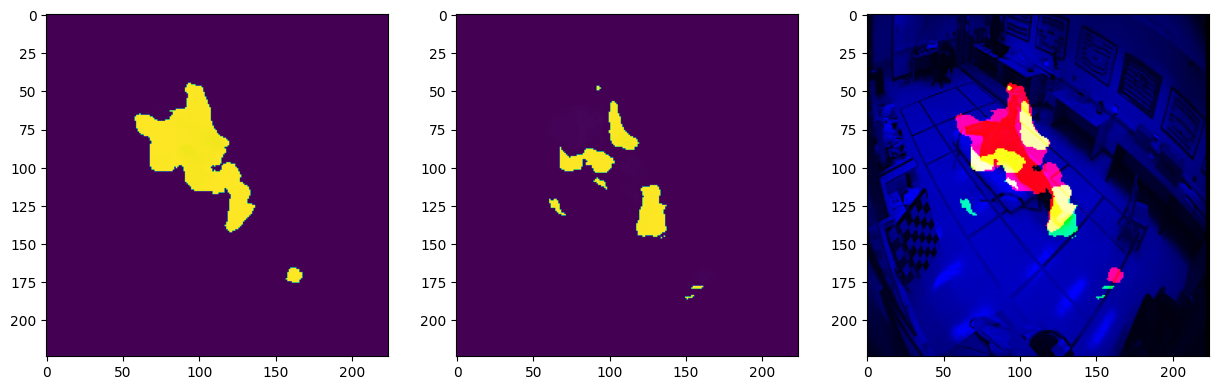

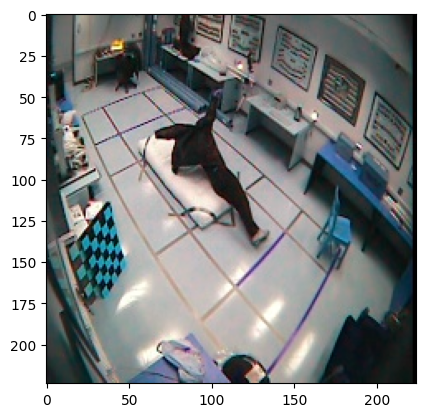

In [18]:
file_name = "chute01_cam1_frames_1083_1113__1104"
np_name = file_name + ".npy"
jpg_name = file_name + ".jpg"
flow = np.load(os.path.join(fall_folder_path, np_name))

#Load the jpg
orig_img = cv2.imread(os.path.join(fall_folder_path, jpg_name))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(flow[:, :, 0])
plt.subplot(1, 3, 2)
plt.imshow(flow[:, :, 1])
plt.subplot(1, 3, 3)
plt.imshow(flow)

plt.figure()
plt.imshow(orig_img)